# Import MNIST data to train discriminator model

In [11]:
import tensorflow as tf
%tensorflow_version 2.x
from tensorflow import keras
print(tf.__version__)

import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, LeakyReLU, Conv2D


(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images.astype("float32")).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.13.0


<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Define generator and discriminator models

In [12]:
def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(784,))) # La entrada es un verctor [1,100] pixels en escala de gris

    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))

    return model

def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12544)             9834496   
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 14, 14, 128)       819328    
 Transpose)                                                      
                                                                 
 batch_normalization_12 (Ba  (None, 14, 14, 128)       512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_10 (Conv2  (None, 14, 14, 64)       

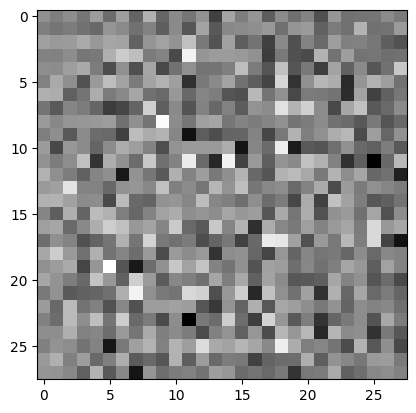

In [13]:
# create random generator
generator = make_generator_model()
generator.summary ()

# generate random image
noise_dim = 784
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# create random discriminator
discriminator = make_discriminator_model()
discriminator.summary ()

# discriminate wether image is real with a random desicion
decision = discriminator(generated_image)
print(decision)

In [19]:
# loss functions design

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    # en real_loss se mide el error entre los unos (reales) y el resultado de la clasificación de una imagen real
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # en fake_loss se mide el error entre los ceros (datos fake) y el resultado de la clasificación de una imagen generada
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # en total_loss sumamos los dos errores y devolvemos el resultado.
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
  # se mide el error entre los unos (reales) y el resultado de la clasificación de una imagen generada
  return cross_entropy(tf.ones_like(fake_output), fake_output)

# optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Train models

In [25]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # Generamos un vector aleatorio [256 (batch_size), 100]

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True) # Obtenemos resultado de discriminacion con un batch de imágenes true
      fake_output = discriminator(generated_images, training=True) # Obtenemos resultado de discr. con las generadas o fake

      gen_loss = generator_loss(fake_output) # Obtenemos la loss del generador
      disc_loss = discriminator_loss(real_output, fake_output) # Obtenemos la loss del discriminador

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # almacenamos la loss del generador
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) # almacenamos loss del discr.

    # aplicamos las loss a través del optimizador en cada caso
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [21]:
grid_size_x= 10
grid_size_y= 10
seed = tf.random.normal([grid_size_x*grid_size_y, noise_dim]) # Generamos una semilla para visualizar nuestro generador aleatorio

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time() # medimos el tiempo que consumimos en cada epoch

    for image_batch in dataset: #para cada lote del dataset de entrenamiento - se procesa el dataset entero en cada epoch-
      gen_loss, disc_loss = train_step(image_batch)    # ejecutamos el entrenamiento -epoch-

    if epoch in [0,29,59,99]:
      generate_images(generator,seed, epoch)  # y generamos unas imágenes para mostrar la evolución de la red generadora en cada época
      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [22]:
def generate_images(model, test_input, epoch=''):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(grid_size_x,grid_size_y))
  for i in range(predictions.shape[0]):
      plt.subplot(grid_size_x, grid_size_y, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray') #127.5 + 127.5
      plt.axis('off')
  plt.savefig("gan_training_epoch%s.png"%str(epoch))
  plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


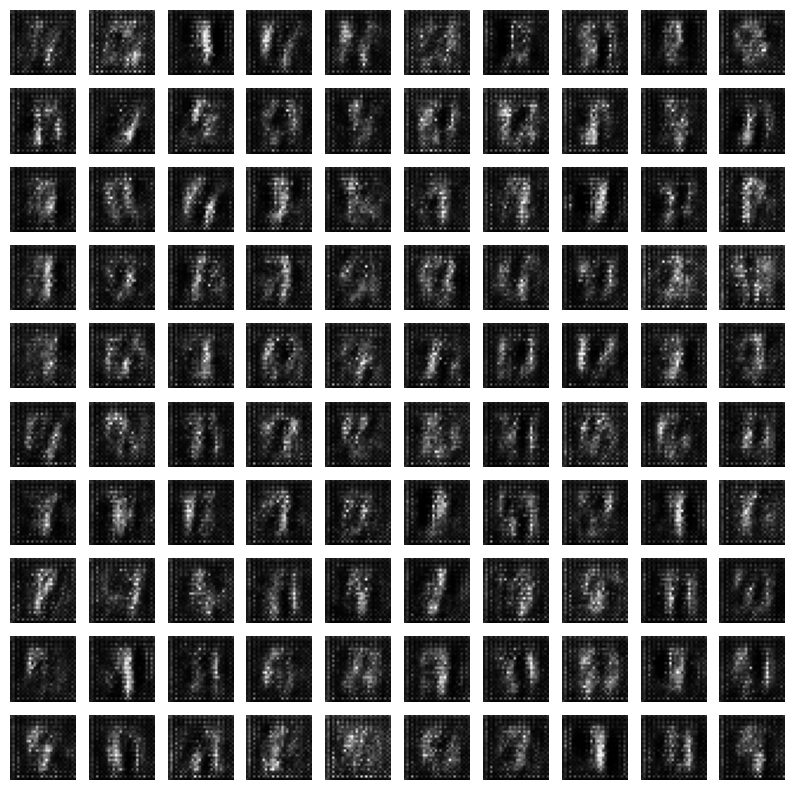

Time for epoch 1 is 30.15199065208435 sec


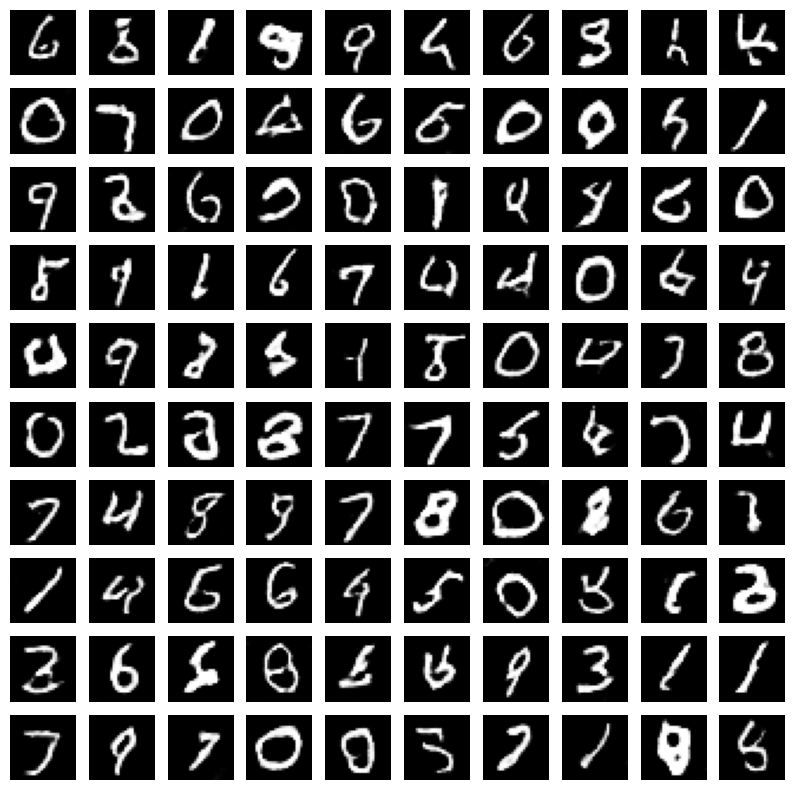

Time for epoch 30 is 20.616390228271484 sec


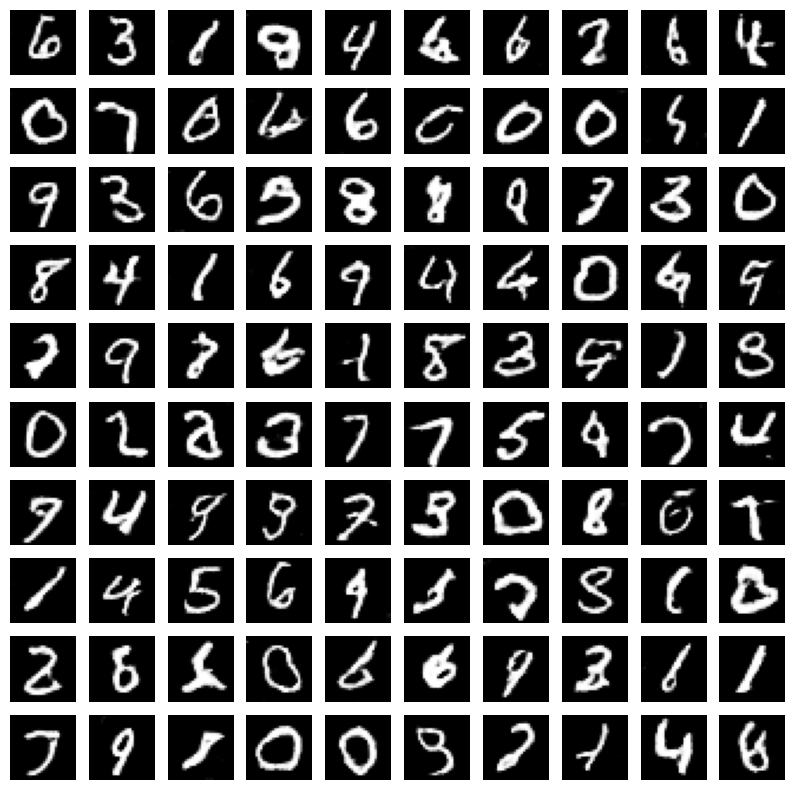

Time for epoch 60 is 17.65358328819275 sec


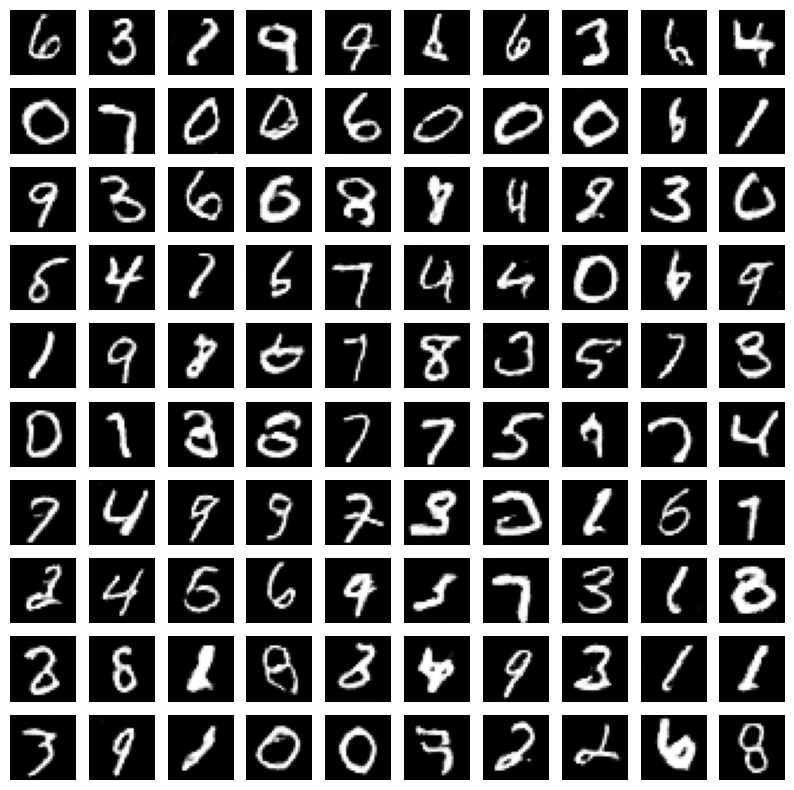

Time for epoch 100 is 23.705727100372314 sec


In [23]:
import time

EPOCHS = 100
train(train_dataset, EPOCHS)

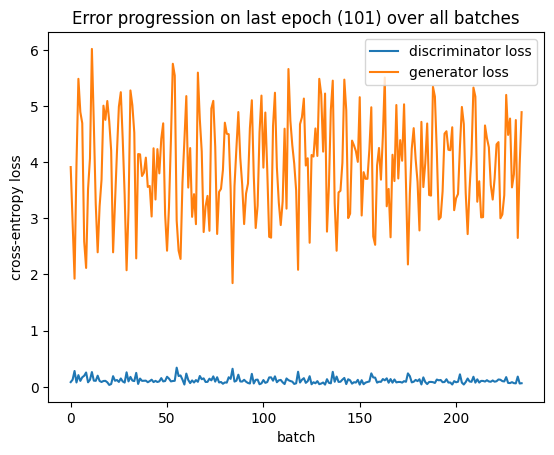

In [37]:
# run a last batch and save errors
gen_loss_l, disc_loss_l = ([],[])
for image_batch in train_dataset:
  gen_loss, disc_loss = train_step(image_batch)
  gen_loss_l.append(gen_loss); disc_loss_l.append(disc_loss)

plt.plot(disc_loss_l); plt.plot(gen_loss_l)
plt.legend(['discriminator loss','generator loss'])
plt.xlabel('batch'); plt.ylabel('cross-entropy loss')
plt.title('Error progression on last epoch (101) over all batches')
plt.savefig('last_epoch_loss')

In [101]:
import pandas as pd

# assign directory
directory = '/content/drive/MyDrive/Colab Notebooks/IA/trabajoLeNet5'

# read our class' images
own_images=pd.read_csv(directory+'/numbers.csv',index_col=0)

# format images
def x_format(x):
  return (1 - float(x) - 127.5) / 127.5  # features' space of [-1,1] as suggested on the implementation

img_digits=own_images.drop(own_images[own_images['label']=='X'].index).iloc[:,:-1].applymap(x_format)
img_x=own_images.drop(own_images[own_images['label']!='X'].index).iloc[:,:-1].applymap(x_format)

# as tensor
img_digits = img_digits.to_numpy().reshape(img_digits.shape[0], 28, 28).astype('float32')
ts_img_digits = tf.convert_to_tensor(img_digits)
img_x = img_x.to_numpy().reshape(img_x.shape[0], 28, 28).astype('float32')
ts_img_x = tf.convert_to_tensor(img_x)

# discriminate images from MNIST database
val_image_scr=discriminator(ts_img_digits).numpy()
x_image_scr=discriminator(ts_img_x).numpy()

# our worst digits according to the discriminator trained on MNIST

In [48]:
print('percentage of fake data in our written dataset: ', sum(val_image_scr<0.5)/sum(val_image_scr>0), '%')

percentage of fake data in our written dataset:  [0.] %


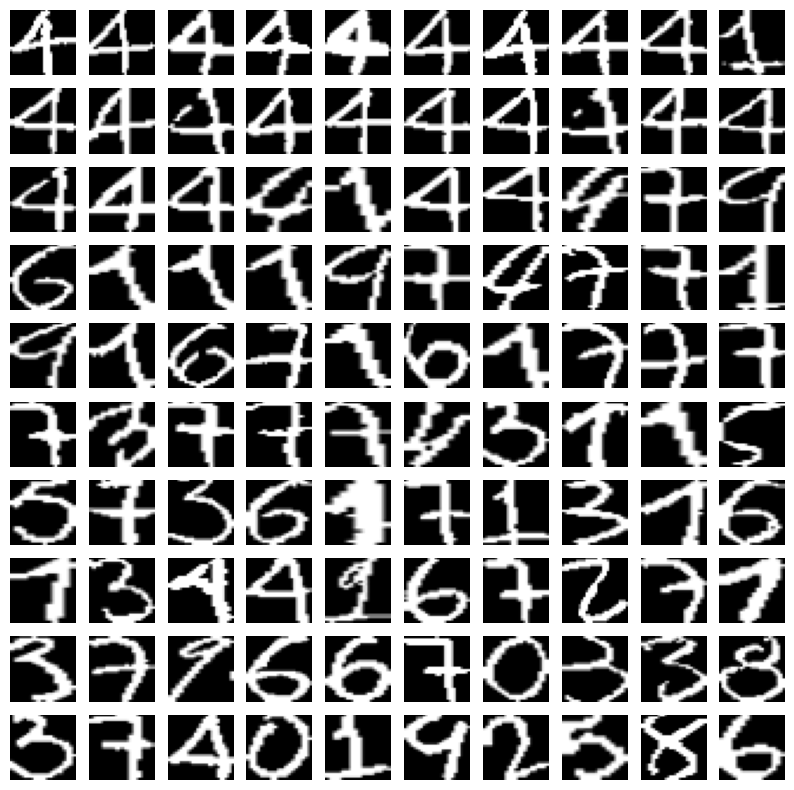

In [102]:
fig = plt.figure(figsize=(grid_size_x,grid_size_y))

for i, ix in enumerate(np.argsort(val_image_scr,axis=0)[0:100]):
  plt.subplot(grid_size_x, grid_size_y, i+1)
  plt.imshow(ts_img_digits[ix[0]], cmap='gray') #127.5 + 127.5
  plt.axis('off')
plt.show()

In [103]:
print('percentage of fake data in our non-human-distinguisable images): ', sum(x_image_scr<0.5)/sum(x_image_scr>0), '%')

percentage of fake data in our non-human-distinguisable images):  [0.] %


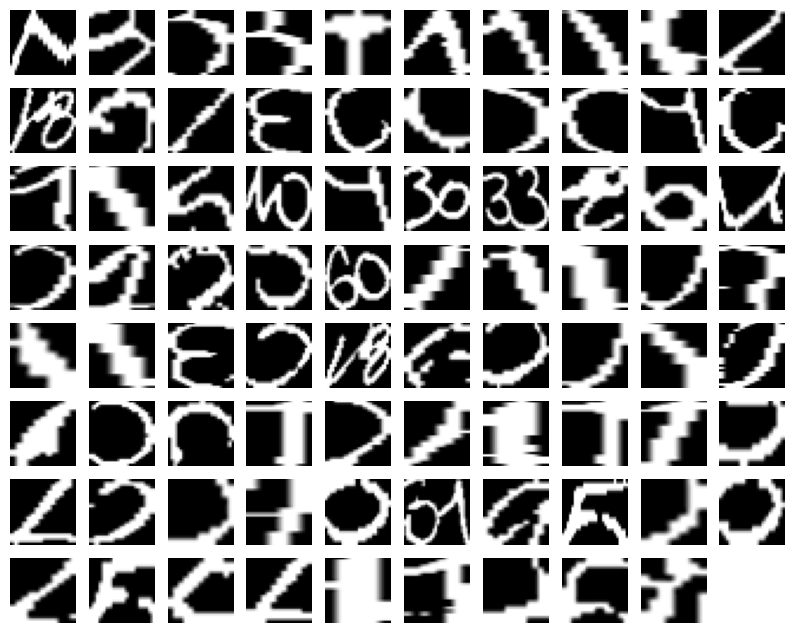

In [104]:
fig = plt.figure(figsize=(grid_size_x,grid_size_y))

for i, ix in enumerate(np.argsort(x_image_scr,axis=0)[0:100]):
  plt.subplot(grid_size_x, grid_size_y, i+1)
  plt.imshow(ts_img_x[ix[0]], cmap='gray') #127.5 + 127.5
  plt.axis('off')
plt.show()

In [100]:
# generate_images(generator, tf.convert_to_tensor(img_digits.iloc[:100].to_numpy()),0)